## CSCI250 Capstone: 
#### By: Carsten Erlander and Jacob States
##### Description
Use a piezoelement, microphone, and button to record notes from a trombone and compare the audio data and piezo data. Then interpret that data by anaylzing the frequency of the notes played.
###### Recording Method
Upon button press begin recording and continue until button is pressed again or after 10 seconds. To record, the program will run two threads gathering data from the piezoelement and microphone.
Potential Challenges: Synced data
###### Storing Data
Once recording halts, both arrays (ideally the same length) will be saved into a single file to be retrieved and analyzed.
###### Data Analysis
- Graph both data sets (Y)
- Graph the fft of the data (Y)
- Determine the notes played (In progress)
- Big Brain: Processing
- Play back the notes on a buzzer (?)

In [1]:
# IMPORTS
import RPi.GPIO as GPIO
import time
import numpy as np
import matplotlib.pyplot as plt
import adcUtil as adc
import pigpio

In [3]:
# Recording (Green) Button Setup
GPIO.setmode(GPIO.BCM)
bPin = 27
GPIO.setup(bPin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
print("Recording Button set to pin:", bPin)
print("Recording Button default to:", GPIO.input(bPin))

# Interrupt (Red) Button Setup
intrPin = 25
GPIO.setup(intrPin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
print("Recording Button set to pin:", intrPin)
print("Interrupt Button default to:", GPIO.input(intrPin))

# Recording LED
ledPin = 26
GPIO.setup(ledPin, GPIO.OUT)
print("Recording LED set to pin:", ledPin)

# Audio Gate pin Setup
gatePin = 24
GPIO.setup(gatePin, GPIO.IN, pull_up_down = GPIO.PUD_DOWN)
print("Audio Gate set to pin:", gatePin)
print("Audio Gate default to:", GPIO.input(gatePin))

# Buzzer pin Setup
buzzPin = 19
duty = 0.5
duration = 3
pi = pigpio.pi(port = 8887)

Recording Button set to pin: 27
Recording Button default to: 0
Recording Button set to pin: 25
Interrupt Button default to: 0
Recording LED set to pin: 26
Audio Gate set to pin: 24
Audio Gate default to: 0


In [5]:
# Recording Button Test
for i in range(5):
    print(GPIO.input(bPin))
    time.sleep(1)

0
0
0
0
0


In [ ]:
# TEST MODULE
# LED on while button is Pressed. Takes button input pin and outputs to another pin to turn on LED.
to = time.time()
t = to
dt = 5                                          # time interval variable
button = GPIO.input(bPin)

while t <= to + dt:
    button = GPIO.input(bPin)
    if button == 1:                             # If button is pressed (internal pull down)
        button = GPIO.input(bPin)               # Check button state
        GPIO.output(ledPin, True)               # Set LED on
        t = time.time()                         # Update time counter
    else:
        button = GPIO.input(bPin)               # If button is unpressed (internal pull down)
        GPIO.output(ledPin, False)              # Set LED off
        t = time.time()                         # update time counter
else:                                           # if t >= to + dt then escape while loop
    GPIO.output(ledPin, False)                  # set LED off

In [24]:
# TEST MODULE
# Try Recording Button loop with Interrupt Button. LED symbolizes recording.
# Should wait until record button is pressed and exit recording loop when time is up or interrupt button is pressed.

try:
    to = time.time()                                # Initial Time
    t  = to                                          # Second time variable at which the interval, dt, will be added  
    dt = 5                                          # time interval variable
    intr = GPIO.input(intrPin)                      # Interrupt variable set to input of interrupt button
    assert intr == 0                                # Asserts unpressed interrupt button (internal pull down)
    
    while t <= to + dt and intr == 0:               # For dt seconds and while interrupt button is unpressed...
        button = GPIO.input(bPin)                      # Check rec button status
        intr   = GPIO.input(intrPin)                   # Check intr button status
        if button == 1:                                # If button is pressed (internal pull down)
            button = GPIO.input(bPin)                    # Check rec button status
            intr   = GPIO.input(intrPin)                 # Check intr button status
            GPIO.output(ledPin, True)                    # Set LED on
            t = time.time()                              # Update time counter
        else:                                          # If rec button is unpressed (internal pull down)
            button = GPIO.input(bPin)                    # Check rec button status
            intr   = GPIO.input(intrPin)                 # check intr button status
            GPIO.output(ledPin, False)                   # Set LED off
            t = time.time()                              # Update time counter
            pass
    
    else:                                           # if t >= to + dt then escape while loop
        GPIO.output(ledPin, False)                     # Set LED off so that button doesnt stay on when loop terminates        

except AssertionError:                           # If interrupt button is pressed exit try loop
    print("Recording Stopped")

finally:                                         # Once try and except are complete print completed recording
    print("Recording Complete")

Recording Complete


In [147]:
# CRITICAL MODULE 1
# Recording with Rec Button, Interrupt Button, rec LED, ADC, and microphone
# Once loop begins it will run for a set amount of time or until the interrupt button is pressed.
# To Record: Begin loop, then press record button in the set time interval. Recording will stop when time is up or when
#     interrupt button is pressed

# EDIT: add error for 0 dimensional array

# Initialize data arrays for time, audio, envelope, and gate
arr_t    = np.ndarray([], dtype = 'float', order = 'C')
arr_aud  = np.ndarray([], dtype = 'float', order = 'C') 
arr_env  = np.ndarray([], dtype = 'float', order = 'C')
arr_gate = np.ndarray([], dtype = 'int', order = 'C')

try:
    to = time.time()                                         # Initial ime
    t  = to                                                  # Time counter
    dt = 10                                                  # Time interval for while loop
    intr = GPIO.input(intrPin)                               # Interrupt variable for interrupt button
    assert intr == 0                                         # Assertion for unpressed interrupt button (internal pull down)
    
    while t <= to + dt and intr == 0:                        # For dt seconds and while interrupt is unpressed...      
        rec  = GPIO.input(bPin)                              # NOTE to start time when rec button is pressed consider
        intr = GPIO.input(intrPin)                           #      putting the while loop within the following if statement
        if rec == 1:                                         # If rec button is pressed...
            rec  = GPIO.input(bPin)                             # Check rec button state
            intr = GPIO.input(intrPin)                          # Check intr button state
            
            GPIO.output(ledPin, True)                           # Turn on LED
            t    = time.time()                                  # record time, aud, env, and gate channels
            aud  = adc.readADC(channel = 0, device = 0)
            env  = adc.readADC(channel = 1, device = 0)
            gate = GPIO.input(gatePin)
            arr_t    = np.append(arr_t, t-to)                   # append time, aud, env, and gate data to respective arrays
            arr_aud  = np.append(arr_aud, aud)                  
            arr_env  = np.append(arr_env, env)
            arr_gate = np.append(arr_gate, gate)
        else:                                                # If rec button is unpressed...
            rec = GPIO.input(bPin)                              # Check rec button state      
            intr = GPIO.input(intrPin)                          # Check intr button state
            
            GPIO.output(ledPin, False)                          # Turn LED off
            t = time.time()                                     # Update time counter
    else:                                                 # Once time interval is complete or interrupted exit while loop
        GPIO.output(ledPin, False)                           # Turn LED off when loop finished

except AssertionError:                                 # If interrupt button is pressed exits while loop
    print("Recording Interrupted")

finally:                                               # Once complete deletes first data point from each array and prints
    arr_t    = arr_t[1:]
    arr_aud  = arr_aud[1:]
    arr_env  = arr_env[1:]
    arr_gate = arr_gate[1:]
    print("Recording Complete")
    print(arr_t, arr_aud, arr_env, arr_gate)
    

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [62]:
# CRITICAL MODULE 2
# Recording with Rec Button, Interrupt Button, rec LED, ADC, microphone (Audio wave), and Piezo
# Once loop begins it will run for a set amount of time or until the interrupt button is pressed.
# To Record: Begin loop, then press record button in the set time interval. Recording will stop when time is up or when
#     interrupt button is pressed

# EDIT: add error for 0 dimensional array

# Initialize data arrays for time, audio, envelope, and gate
arr_t    = np.ndarray([], dtype = 'float', order = 'C')
arr_aud  = np.ndarray([], dtype = 'float', order = 'C') 
arr_piz  = np.ndarray([], dtype = 'float', order = 'C')
arr_gate = np.ndarray([], dtype = 'int', order = 'C')

try:
    to = time.time()                                         # Initial ime
    t  = to                                                  # Time counter
    dt = 15                                                  # Time interval for while loop
    intr = GPIO.input(intrPin)                               # Interrupt variable for interrupt button
    assert intr == 0                                         # Assertion for unpressed interrupt button (internal pull down)
    
    while t <= to + dt and intr == 0:                        # For dt seconds and while interrupt is unpressed...      
        rec  = GPIO.input(bPin)                              # NOTE to start time when rec button is pressed consider
        intr = GPIO.input(intrPin)                           #      putting the while loop within the following if statement
        if rec == 1:                                         # If rec button is pressed...
            rec  = GPIO.input(bPin)                             # Check rec button state
            intr = GPIO.input(intrPin)                          # Check intr button state
            
            GPIO.output(ledPin, True)                           # Turn on LED
            t    = time.time()                                  # record time, aud, env, and gate channels
            aud  = adc.readADC(channel = 0, device = 0)
            piz  = adc.readADC(channel = 1, device = 0)
            gate = GPIO.input(gatePin)
            arr_t    = np.append(arr_t, t-to)                   # append time, aud, env, and gate data to respective arrays
            arr_aud  = np.append(arr_aud, aud)                  
            arr_piz  = np.append(arr_piz, piz)
            arr_gate = np.append(arr_gate, gate)
        else:                                                # If rec button is unpressed...
            rec = GPIO.input(bPin)                              # Check rec button state      
            intr = GPIO.input(intrPin)                          # Check intr button state
            
            GPIO.output(ledPin, False)                          # Turn LED off
            t = time.time()                                     # Update time counter
    else:                                                 # Once time interval is complete or interrupted exit while loop
        GPIO.output(ledPin, False)                           # Turn LED off when loop finished

except AssertionError:                                 # If interrupt button is pressed exits while loop
    print("Recording Interrupted")

finally:                                               # Once complete deletes first data point from each array and prints
    arr_t    = arr_t[1:]
    arr_aud  = arr_aud[1:] - np.mean(arr_aud)
    arr_piz  = arr_piz[1:] - np.mean(arr_piz)
    arr_gate = arr_gate[1:]
    print("Recording Complete")
    save = input("Do you want to save this file? (y/n)")
    if save == 'y':
        file_name = input("Enter name for file ")
        file_name = file_name + '.npz'
        np.savez(file_name, arr_t, arr_aud, arr_gate, arr_piz)
        print(file_name, '\n', np.load(file_name))
        print('With arrays:', '\n', np.load(file_name).files)
    else:
        print("Data not saved")
        pass

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [6]:
import os
os.remove('A5_sine.npz')

In [10]:
# List Files to Load
%ls -l *.npz

-rw-r--r-- 1 pi pi 198894 Dec  5 19:40 A4_sine.npz
-rw-r--r-- 1 pi pi 129762 Dec  5 18:08 capstone_B1.npz
-rw-r--r-- 1 pi pi 144322 Dec  5 18:39 capstone_Bb2.npz
-rw-r--r-- 1 pi pi 124582 Dec  4 15:05 capstone_Bb.npz
-rw-r--r-- 1 pi pi 131946 Dec  5 16:45 capstone_Bb_phone.npz
-rw-r--r-- 1 pi pi 113970 Dec  5 17:11 capstone_Bb_sine2.npz
-rw-r--r-- 1 pi pi 142054 Dec  5 16:46 capstone_Bb_sine.npz
-rw-r--r-- 1 pi pi 133010 Dec  4 15:05 capstone_D.npz
-rw-r--r-- 1 pi pi 128138 Dec  5 18:40 capstone_F.npz
-rw-r--r-- 1 pi pi 123098 Dec  5 18:01 capstone_G2.npz
-rw-r--r-- 1 pi pi 112570 Dec  5 18:04 capstone_G3.npz
-rw-r--r-- 1 pi pi 220958 Dec  5 18:35 capstone_G4.npz
-rw-r--r-- 1 pi pi 144770 Dec  4 15:03 capstone_g.npz
-rw-r--r-- 1 pi pi 154262 Dec  5 17:37 capstone_G.npz
-rw-r--r-- 1 pi pi  53490 Dec  5 17:35 capstone_test2.npz
-rw-r--r-- 1 pi pi 206622 Dec  5 17:45 test.npz


In [43]:
# Choose File to Load

f_name = "C4_sine.npz"

file = np.load(f_name)

t    = file['arr_0']
aud  = file['arr_1']
gate = file['arr_2']
piz  = file['arr_3']

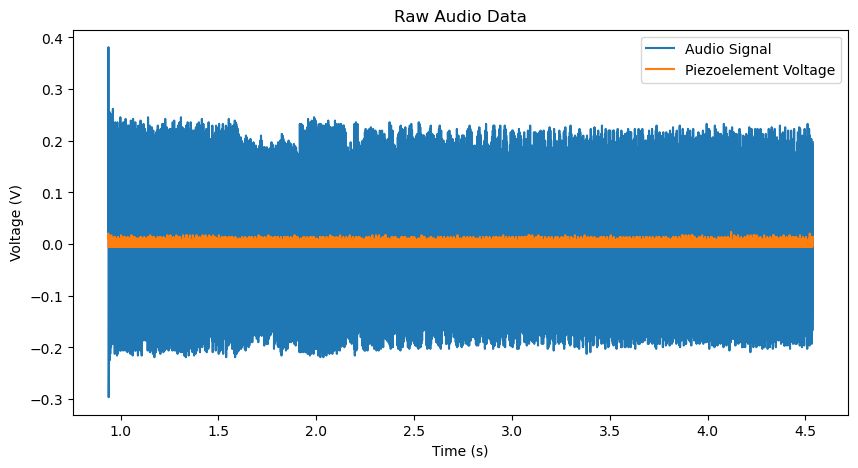

In [44]:
# Plots of Raw Data
import matplotlib.pyplot as plt

plt.figure(figsize =(10,5))
plt_aud = plt.plot(t, aud, label = 'Audio Signal')
plt_env = plt.plot(t, piz, label = 'Piezoelement Voltage')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('Raw Audio Data')
plt.show()

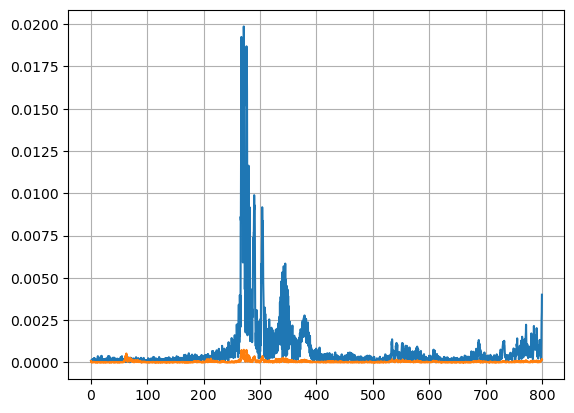

In [45]:
# Plots of Transformed Data
from scipy.fft import fft, fftfreq

# Number of sample points
N = len(aud)

# sample spacing
T = 1.0 / 1600.0

f_aud = fft(aud)
f_piz = fft(piz)

xf = fftfreq(N, T)[1:N//2]      # Generates the frequency axis for N-even to give positive frequencies (explains spike at 0)

import matplotlib.pyplot as plt

fft_aud = 1/N * np.abs(f_aud[1:N//2])
fft_piz = 1/N * np.abs(f_piz[1:N//2])

plt.plot(xf, fft_aud)
plt.plot(xf, fft_piz)

plt.grid()

plt.show()

In [32]:
# Mean Filter
def moving_avg(input, win):
    avg = np.ndarray([], dtype = 'float', order = 'C')   # defines empty avg array
    mov_sum = np.sum(input[:int(win)])                   # defines sum of values in window
    avg = np.append(avg, mov_sum/win)
    for i in range(int(len(input) - win)):
        mov_sum += (input[int(i + win)] - input[i]) # Shifts window to the right by one unit
        avg = np.append(avg, mov_sum/win)
        
    return avg

In [47]:
win = 50
filt_aud = moving_avg(fft_aud, win)
print(len(filt_aud), filt_aud)
print(len(fft_aud), fft_aud)

2595 [0.00400814 0.00012647 0.00012606 ... 0.00103812 0.00108337 0.00114549]
2643 [9.73965091e-05 6.97198044e-05 2.96262913e-05 ... 2.56774390e-03
 2.95947656e-03 4.00814272e-03]


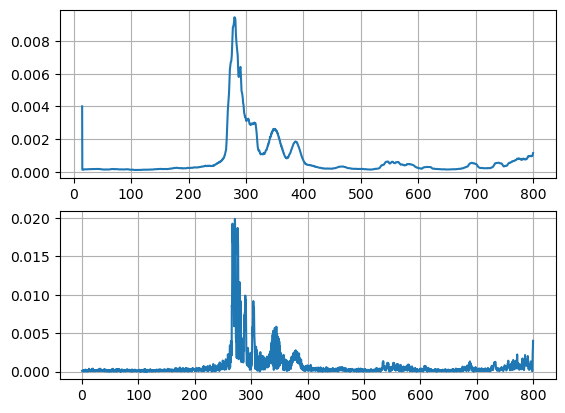

In [48]:
N = len(aud)

# sample spacing
T = 1.0 / 1600.0

xf = fftfreq(N, T)[1:N//2]      # Generates the frequency axis for N-even to give positive frequencies (explains spike at 0)
xff = fftfreq(N , T)[1:N//2] 
import matplotlib.pyplot as plt

plt.subplot(2,1,1)
plt.plot(xff[win-2:], filt_aud)
plt.grid()

plt.subplot(2,1,2)
plt.plot(xf, fft_aud)


plt.grid()

plt.show()

In [49]:
freq_aud = xf[filt_aud.argmax()]
print(freq_aud)

265.35552193645987


In [37]:
# Frequency Dictonary
#Note names, index is how many pitches above C0 the note is
#frequency converted to index value by index=12log(base2)(frequency)-48
pitches=['C0','Db0','D0','Eb0','E0','F0','Gb0','G0','Ab0','A0','Bb0','B0',
         'C1','Db1','D1','Eb1','E1','F1','Gb1','G1','Ab1','A1','Bb1','B1',
         'C2','Db2','D2','Eb2','E2','F2','Gb2','G2','Ab2','A2','Bb2','B2',
         'C3','Db3','D3','Eb3','E3','F3','Gb3','G3','Ab3','A3','Bb3','B3',
         'C4','Db4','D4','Eb4','E4','F4','Gb4','G4','Ab4','A4','Bb4','B4',
         'C5','Db5','D5','Eb5','E5','F5','Gb5','G5','Ab5','A5','Bb5','B5',
         'C6','Db6','D6','Eb6','E6','F6','Gb6','G6','Ab6','A6','Bb6','B6',
         'C7','Db7','D7','Eb7','E7','F7','Gb7','G7','Ab7','A7','Bb7','B7',
         'C8','Db8','D8','Eb8','E8','F8','Gb8','G8','Ab8','A8','Bb8','B8']

In [50]:
import math

def noteName(freq):                     #function to convert frequency to note name
    index=int(12*math.log2(freq)-48)    #convert frequency to index value of pitches list
    return pitches[index]               #return note name at index 

In [51]:
note = noteName(freq_aud)
print(note)

C4


In [61]:
duty = 0.5
freq = 440

pi = pigpio.pi(port = 8887)
pi.set_PWM_frequency(buzzPin, int(freq_aud))             # set frequency
pi.set_PWM_dutycycle(buzzPin, int(duty * 255)) # set duty cycle
time.sleep(duration)

# turn the buzzer off
pi.set_PWM_dutycycle(buzzPin, 0)

0

In [60]:
https://www.youtube.com/watch?v=nl9TZanwbBk
https://docs.scipy.org/doc/scipy/reference/generated/scipy.fft.fft.html#scipy.fft.fft

SyntaxError: invalid syntax (2184906537.py, line 1)